# Tarea 2 - Computación Cienctífica y Ciencia de los Datos
## Medio elástico discreto
### Vicente Mieres / 21.082.122-8

In [16]:
%matplotlib widget

In [17]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Parte 1 - Simulación de trayectoria

1.1 Funciones Principales

In [18]:
def matrix_init(n, k_const=1.0):
    N = n * n
    dim = 2 * N
    K = np.zeros((dim, dim))
    
    def idx(i, j, coord):
        masa = i * n + j
        return 2 * masa + coord

    for i in range(n):
        for j in range(n):
            for coord in [0,1]:
                diagonal_pos = idx(i,j,coord)
                suma_k_vecinos = 0
                vecinos = []
                if i+1 < n:
                    vecinos.append(idx(i+1,j,coord))
                    suma_k_vecinos += k_const
                if i-1 >= 0:
                    vecinos.append(idx(i-1,j,coord))
                    suma_k_vecinos += k_const
                if j+1 < n:
                    vecinos.append(idx(i,j+1,coord))
                    suma_k_vecinos += k_const
                if j-1 >= 0:
                    vecinos.append(idx(i,j-1,coord))
                    suma_k_vecinos += k_const
                
                K[diagonal_pos, diagonal_pos] = suma_k_vecinos
                for v in vecinos:
                    K[diagonal_pos, v] = -k_const
    return K


def get_values(K):
    eigvals, eigvecs = np.linalg.eig(K)

    # Ordenar por valor absoluto
    idx_sorted = np.argsort(np.abs(eigvals))
    eigvals = eigvals[idx_sorted]
    eigvecs = eigvecs[:, idx_sorted]

    # omega
    omega = np.sqrt(np.clip(eigvals, a_min=0, a_max=None))

    return eigvecs, omega

def simulate_trayectory(t_vect, R0, V0, A, omega):
    """
    Simula R(t) para cada tiempo en t_vect.

    Parámetros:
    - t_vect: array 1D con tiempos, shape (T,)
    - R0: vector condiciones iniciales posiciones, shape (D,)
    - V0: vector condiciones iniciales velocidades, shape (D,)
    - A: matriz autovectores, shape (D, D)
    - omega: vector frecuencias, shape (D,)

    Retorna:
    - Rt: array con resultados para cada t, shape (T, D)
    """

    D = R0.shape[0]
    T = t_vect.shape[0]

    AR0 = A.T @ R0      
    AV0 = A.T @ V0     

    omega_mat = omega.reshape((1, D)) 
    t_mat = t_vect.reshape((T, 1))     

    f_t = np.cos(omega_mat * t_mat) 

    with np.errstate(divide='ignore', invalid='ignore'):
        g_t = np.where(omega_mat != 0,
                       np.sin(omega_mat * t_mat) / omega_mat,
                       t_mat)  

    term1 = f_t * AR0
    term2 = g_t * AV0

    sum = term1 + term2  

    Rt = sum @ A.T

    return Rt

def animation(Rt, n, t_vect, intervalo=20):
    """
    Anima la malla de masas moviéndose con las posiciones Rt.

    Parámetros:
    - Rt: array con posiciones en cada tiempo, shape (T, 2*n^2)
    - n: tamaño de la malla (n x n)
    - t_vect: vector de tiempos (T,)
    - intervalo: ms entre frames de animación
    """

    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlim(-1, n)
    ax.set_ylim(-1, n)
    ax.set_aspect('equal')
    ax.set_title("Simulación Movimiento Medio Elástico")
    ax.grid(True)

    # Coordenadas iniciales en reposo, grilla regular
    x_eq = np.repeat(np.arange(n), n)
    y_eq = np.tile(np.arange(n), n)

    # Scatter plot para posiciones (se actualizará)
    scat = ax.scatter(x_eq, y_eq, c='blue')

    def update(frame):
        # frame: índice de tiempo
        R_t = Rt[frame]  # shape (2*n^2,)
        x_t = x_eq + R_t[0::2]  # posiciones x + desplazamientos
        y_t = y_eq + R_t[1::2]  # posiciones y + desplazamientos
        scat.set_offsets(np.c_[x_t, y_t])
        ax.set_xlabel(f"t = {t_vect[frame]:.2f} s")
        return scat,

    anim = FuncAnimation(fig, update, frames=len(t_vect), interval=intervalo, blit=True)
    anim.save("mi_animacion.gif", writer="ffmpeg", fps=30)


MovieWriter ffmpeg unavailable; using Pillow instead.


[[ 2.  0. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  3.  0. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  3.  0. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  2.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  2.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  3.  0. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  3.  0. -1.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0. -1.  0.  4.  0. -1.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0. -1.  0.  4.  0. -1.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0. -1.  0.  3.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0. -1.  0.  3.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  2.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.

c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:558: ComplexWarning: Casting complex values to real discards the imaginary part
  (np.asanyarray(self.convert_xunits(offsets[:, 0]), float),
c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:559: ComplexWarning: Casting complex values to real discards the imaginary part
  np.asanyarray(self.convert_yunits(offsets[:, 1]), float)))


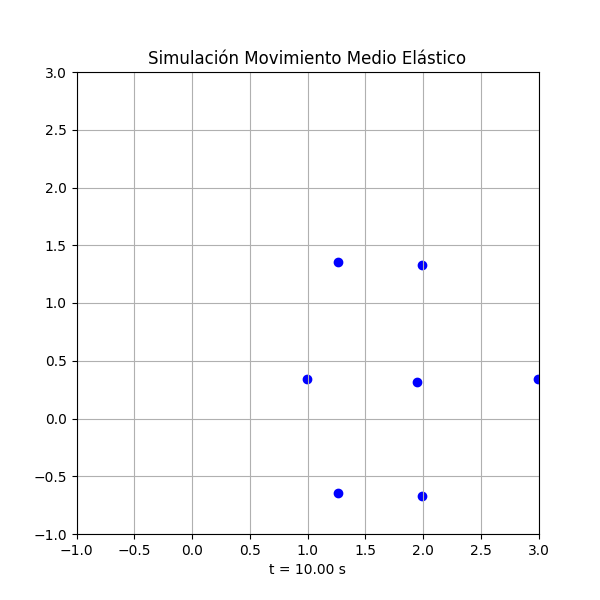

In [ ]:
# Ejemplo simple para acordarme como se usa

# Parámetros
n = 3  # tamaño de la malla
K = matrix_init(n)

print(K)

# Calcular valores y vectores propios
eigvecs, omega = get_values(K)

# Condiciones iniciales
D = 2 * n * n
R0 = np.zeros(D)           # posiciones iniciales en equilibrio
V0 = np.zeros(D)           # velocidades iniciales en cero
center_mass = 4            # índice de masa central en malla 3x3
V0[2*center_mass] = 1.0    # velocidad inicial en x de la masa central

# Vector de tiempos
t_vect = np.linspace(0, 10, 300)

# Simular trayectoria
Rt = simulate_trayectory(t_vect, R0, V0, eigvecs, omega)

# Rt tiene forma (300, 18): posiciones desplazadas para cada tiempo
print("Simulación lista. Rt shape:", Rt.shape)


animation(Rt, n, t_vect)
